In [1]:
import math
import pandas as pd
import tqdm
import numpy as np

import torch
import torch.utils.data as data
import torch.optim as optim

from MINE import controller, datasets, losses, models

In [89]:
import matplotlib
font = {'family' : 'Georgia',
#        'weight' : 'bold',
        'size'   : 14}
matplotlib.rc('font', **font)

In [2]:
def experiment(target_value):
    data_loader = data.DataLoader(
        datasets.IntegerPairDataset(
            number_of_cases=16,
            x_encoding='one_hot',
            y_encoding='one_hot',
            transform=datasets.TransformToTensor()
        ),
        batch_size=100,
    )
    loss = losses.imine_loss(target_value=target_value, regularizer_weight=0.1)
    network = models.ConcatNet(16, 64)
    optimizer = optim.SGD(network.parameters(), lr=0.1)

    agent = controller.MINEController(
        data_loader=data_loader, loss=loss, network=network, optimizer=optimizer
    )
    
    agent.to(0)
    agent.train()
    for i in tqdm.tqdm(range(1500)):
        agent.step()

    return agent

In [3]:
cs = [-5, -2, 0, 2, 5]
histories = []
for c in cs:
    histories.append(experiment(c).history)

100%|██████████| 1500/1500 [00:26<00:00, 57.34it/s]


In [10]:
def get_t(history, batch_size=100):
    t = []
    for i in range(0, len(history), batch_size):
        t.append(np.average(history.joint_value[i:i+batch_size]))
    return np.array(t)

def get_et(history, batch_size=100):
    et = []
    for i in range(0, len(history), batch_size):
        et.append(np.log(np.average(np.exp(history.marginal_value[i:i+batch_size]))))
    return np.array(et)

<IPython.core.display.Javascript object>


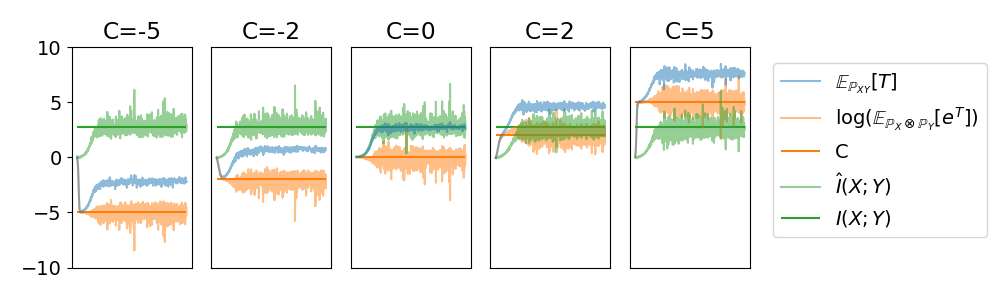

In [128]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
for i, c in enumerate(cs):
    plt.subplot(1, 5, i+1)

    t = get_t(histories[i])
    et = get_et(histories[i])
    mi = t-et

    plt.plot(et, alpha=0.5, label='$\log(\mathbb{E}_{\mathbb{P}_X \otimes \mathbb{P}_Y}[e^{T}])$' if i == 0 else None, c='C1')
    plt.plot(mi, alpha=0.5, label='$\hat{I}(X; Y)$' if i == 0 else None, c='C2')
    plt.plot(t, alpha=0.5, label='$\mathbb{E}_{\mathbb{P}_{X Y}}[T]$' if i == 0 else None, c='C0')
    plt.hlines(np.log(16), 0, 1500, label='$I(X;Y)$' if i == 0 else None, color='C2')
    plt.hlines(c, 0, 1500, label='C' if i == 0 else None, color='C1')
    plt.ylim(-10, 10)
    plt.title(f'C={c}')

    plt.xticks([])
    if i != 0:
        plt.yticks([])

plt.tight_layout()
handles, labels = plt.gcf().axes[0].get_legend_handles_labels()
order = [2, 0, 4, 1, 3]
plt.gcf().legend(
    [handles[idx] for idx in order],[labels[idx] for idx in order],
    ncol=1, loc='center', bbox_to_anchor=(0.88, 0.5)
)
plt.gcf().subplots_adjust(right=0.75)
plt.show()

In [112]:
plt.gcf().axes[0]

<IPython.core.display.Javascript object>


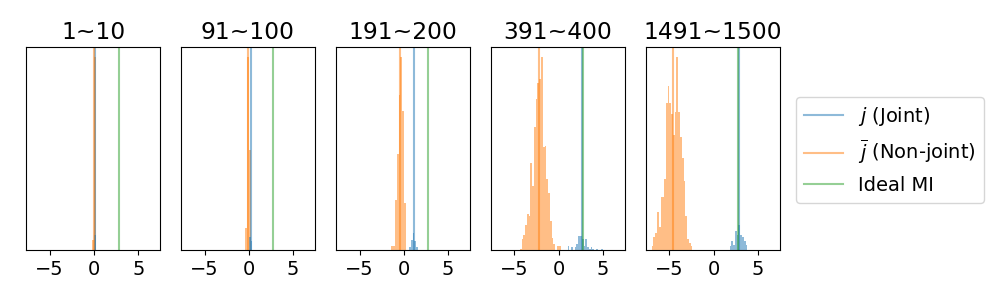

In [143]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
for i, start_iter in enumerate((0, 90, 190, 390, 1490)):
    plt.subplot(1, 5, i+1)

    mid = 0
    njs = histories[2][(histories[2].is_joint_case == 0) & (histories[2].index >= start_iter * 100) & (histories[2].index <  start_iter * 100 + 1000)].marginal_value
    js = histories[2][(histories[2].is_joint_case == 1) & (histories[2].index >= start_iter * 100) & (histories[2].index <  start_iter * 100 + 1000)].marginal_value

    plt.axvline(np.average(js), color='C0', label='$j$ (Joint)' if i == 0 else None, alpha=0.5)
    plt.axvline(np.average(njs), color='C1', label='$\overline{j}$ (Non-joint)' if i == 0 else None, alpha=0.5)
    plt.axvline(np.log(16), color='C2', label='Ideal MI' if i == 0 else None, alpha=0.5)
    
    njs_hst = plt.hist(
        njs,
        bins=np.arange(mid-7, mid+7, 0.2),
        alpha=0.5,
        color='C1',
    )
    js_hst = plt.hist(
        js,
        bins=np.arange(mid-7, mid+7, 0.2),
        alpha=0.5,
        color='C0',
    )
    
    plt.title(f'{start_iter+1}~{start_iter+10}')
    plt.yticks([])

plt.tight_layout()
plt.gcf().legend(ncol=1, loc='center', bbox_to_anchor=(0.89, 0.5))
plt.gcf().subplots_adjust(right=0.78)
plt.show()